In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import gc
import numpy as np

from keras import backend as K
from sklearn.metrics import fbeta_score
from keras.layers import Conv2D, Dense, LSTM, Flatten, MaxPooling2D, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import fbeta_score
from tqdm import tqdm
from sklearn.utils import shuffle

import cv2
from PIL import Image
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential 

import seaborn as sns
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, History

# Dataset

In [3]:

path = pd.read_csv(r"C:\Users\clemi\Downloads\planet-understanding-the-amazon-from-space\train_v2.csv\train_v2.csv")#Place the train.csv file

#Two lists to store images and labels
x_train = []
y_train = []

# Flatten the list of tags
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in path['tags'].values])))

# Create a label map for the unique tags in the dataset
label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

# Loop through the training DataFrame
for f, tags in tqdm(path.values, miniters=1000):
    # Read the image file
    img = cv2.imread(r'C:\Users\clemi\Downloads\Sidia\train-jpg\train-jpg/{}.jpg'.format(f))
    # Resize the image to (64, 64)
    targets = np.zeros(17)
    # Loop through the additional test files DataFrame
    for t in tags.split(' '):
        # Set the corresponding target value to 1
        targets[label_map[t]] = 1 
    # Resize the image to (64, 64)
    x_train.append(cv2.resize(img, (64, 64)))  
    y_train.append(targets)


x_train = np.array(x_train, np.float16) / 255.
y_train = np.array(y_train, np.uint8)

100%|███████████████████████████████████████████████████████████████████████████| 40479/40479 [00:40<00:00, 996.50it/s]


# Train x  Val

In [4]:
#Separating training and validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, shuffle = True, random_state = 1)

print("Train data shape:",x_train.shape)
print("Train label shape:",y_train.shape)

print("Validation data shape:",x_val.shape)
print("Validation label shape:",y_val.shape)



Train data shape: (32383, 64, 64, 3)
Train label shape: (32383, 17)
Validation data shape: (8096, 64, 64, 3)
Validation label shape: (8096, 17)


# Evaluation Metrics

In [8]:
def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 2

    y_pred = K.clip(y_pred, 0, 1)

    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

# MobNet - Img 64x64

In [6]:
# MobileNet
input_shape = (64,64,3)
from tensorflow.keras.applications import MobileNet

def MobNet(input_shape):
    
    #Load the MobileNet architecture
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
    # Freeze MobileNet weights so they are not updated during training
    for layer in base_model.layers:
        layer.trainable = False

    # Add additional layers on top of MobileNet
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(17, activation='sigmoid')(x)

    # Create the final model
    model_MobNet = Model(inputs=base_model.input, outputs=predictions)

    # compile the model
    model_MobNet.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta,'accuracy'])
    return model_MobNet

In [7]:
#Calling the previously created function and passing the input parameter
model_MobNet = MobNet(input_shape = (64,64,3))

# Traning Model
historyMOB =model_MobNet.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=128)


Epoch 1/10
253/253 [==============================] - 45s 169ms/step - loss: 0.3024 - fbeta: 0.6836 - accuracy: 0.3699 - val_loss: 0.2122 - val_fbeta: 0.7257 - val_accuracy: 0.2985
Epoch 2/10
253/253 [==============================] - 43s 170ms/step - loss: 0.2001 - fbeta: 0.7303 - accuracy: 0.2940 - val_loss: 0.1888 - val_fbeta: 0.7376 - val_accuracy: 0.2746
Epoch 3/10
253/253 [==============================] - 42s 165ms/step - loss: 0.1841 - fbeta: 0.7418 - accuracy: 0.2723 - val_loss: 0.1807 - val_fbeta: 0.7442 - val_accuracy: 0.2558
Epoch 4/10
253/253 [==============================] - 43s 168ms/step - loss: 0.1765 - fbeta: 0.7478 - accuracy: 0.2656 - val_loss: 0.1764 - val_fbeta: 0.7484 - val_accuracy: 0.2516
Epoch 5/10
253/253 [==============================] - 42s 167ms/step - loss: 0.1718 - fbeta: 0.7523 - accuracy: 0.2586 - val_loss: 0.1738 - val_fbeta: 0.7503 - val_accuracy: 0.2437
Epoch 6/10
253/253 [==============================] - 43s 172ms/step - loss: 0.1685 - fbeta: 0.

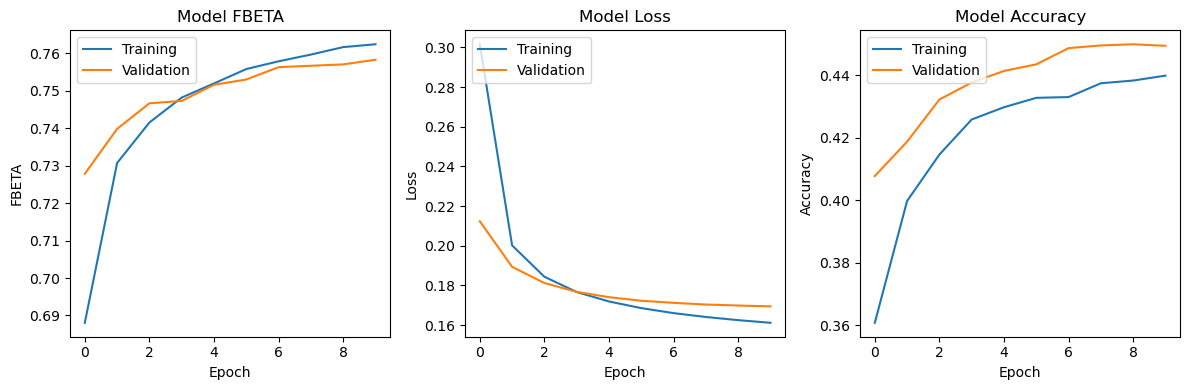

In [29]:
# Plot the training and validation accuracy and loss curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(historyMOB.history['fbeta'])
plt.plot(historyMOB.history['val_fbeta'])
plt.title('Model FBETA')
plt.ylabel('FBETA')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

plt.subplot(1, 3, 2)
plt.plot(historyMOB.history['loss'])
plt.plot(historyMOB.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

plt.subplot(1, 3, 3)
plt.plot(historyMOB.history['accuracy'])
plt.plot(historyMOB.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [33]:
# Loading the test images
samplesub = pd.read_csv(r"C:\Users\clemi\Downloads\Sidia\sample_submission_v2.csv")

test = samplesub[0 : 40669]
files = samplesub[40669 : ]

# Initialize an empty list to store the images
x_test = []
y_test = []
# Loop through the test DataFrame

for image_name, tags in tqdm(test.values, miniters=1000):
    # Read the image file
    arr = cv2.imread(r'C:\Users\clemi\Downloads\Sidia\test-jpg\test-jpg\test-jpg/{}.jpg'.format(image_name))
    # Resize the image to (64, 64)
    x_test.append(cv2.resize(arr, (64, 64)))
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    y_test.append(targets)
    
for image_name, tags in tqdm(files.values, miniters=1000):
    # Read the image file
    arr = cv2.imread(r'C:\Users\clemi\Downloads\Sidia\test-jpg-additional\test-jpg-additional/{}.jpg'.format(image_name))
    # Resize the image to (64, 64)
    x_test.append(cv2.resize(arr, (64, 64)))
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    y_test.append(targets)

# Convert the list of images to a numpy array and normalize the pixel values
x_test = np.array(x_test, np.float16)/255.0

100%|██████████████████████████████████████████████████████████████████████████| 20522/20522 [00:20<00:00, 1006.01it/s]


In [34]:
# test dataset
y_test = np.array(y_test, np.uint8)

_, x_test, _, y_test = train_test_split(x_test, y_test, test_size = 0.3, shuffle = True, random_state = 1)

print("test data shape:",x_test.shape)
print("test label shape:",y_test.shape)

test data shape: (18358, 64, 64, 3)
test label shape: (18358, 17)


In [35]:
# Evaluate the model on the test set
test_loss,test_fbeta,test_accuracy = model_MobNet.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test F-beta:", test_fbeta)

574/574 [==============================] - 21s 37ms/step - loss: 0.8318 - fbeta: 0.3863 - accuracy: 0.0087
Test Loss: 0.8318162560462952
Test Accuracy: 0.008661074563860893
Test F-beta: 0.386281281709671


In [10]:
# # Evaluate the model on the val set
val_loss,val_fbeta,val_accuracy = model_MobNet.evaluate(x_val, y_val)
print("val Loss:", val_loss)
print("val Accuracy:", val_accuracy)
print("val F-beta:", val_fbeta)

253/253 [==============================] - 10s 39ms/step - loss: 0.1695 - fbeta: 0.7563 - accuracy: 0.2363
val Loss: 0.1695236712694168
val Accuracy: 0.23628953099250793
val F-beta: 0.7563274502754211


# MobNet - IMG 128x128

In [36]:
#Place the train.csv file
path = pd.read_csv(r"C:\Users\clemi\Downloads\planet-understanding-the-amazon-from-space\train_v2.csv\train_v2.csv")

#Two lists to store images and labels
x_train = []
y_train = []

# Flatten the list of tags
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in path['tags'].values])))

# Create a label map for the unique tags in the dataset
label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

# Loop through the training DataFrame
for f, tags in tqdm(path.values, miniters=1000):
    # Read the image file
    img = cv2.imread(r'C:\Users\clemi\Downloads\Sidia\train-jpg\train-jpg/{}.jpg'.format(f))
    # Resize the image to (64, 64)
    targets = np.zeros(17)
    # Loop through the additional test files DataFrame
    for t in tags.split(' '):
        # Set the corresponding target value to 1
        targets[label_map[t]] = 1 
    # Resize the image to (64, 64)
    x_train.append(cv2.resize(img, (128, 128)))  
    y_train.append(targets)

# Normalization
x_train = np.array(x_train, np.float16) / 255.
y_train = np.array(y_train, np.uint8)

100%|███████████████████████████████████████████████████████████████████████████| 40479/40479 [01:34<00:00, 426.51it/s]


In [37]:
# Traning and Validation dataset
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, shuffle = True, random_state = 1)

print("Train data shape:",x_train.shape)
print("Train label shape:",y_train.shape)

print("Validation data shape:",x_val.shape)
print("Validation label shape:",y_val.shape)



Train data shape: (32383, 128, 128, 3)
Train label shape: (32383, 17)
Validation data shape: (8096, 128, 128, 3)
Validation label shape: (8096, 17)


In [44]:
#Calling the previously created function and passing the new input parameter
model_MobNet2 = MobNet(input_shape = (128,128,3))

# traning Model
historyMOB2 = model_MobNet2.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=128)

17225924/17225924 [==============================] - 2s 0us/step
Epoch 1/10
253/253 [==============================] - 162s 628ms/step - loss: 0.1755 - fbeta: 0.7596 - accuracy: 0.4274 - val_loss: 0.1406 - val_fbeta: 0.8025 - val_accuracy: 0.4765
Epoch 2/10
253/253 [==============================] - 144s 571ms/step - loss: 0.1340 - fbeta: 0.8071 - accuracy: 0.4759 - val_loss: 0.1327 - val_fbeta: 0.8110 - val_accuracy: 0.4728
Epoch 3/10
253/253 [==============================] - 149s 590ms/step - loss: 0.1268 - fbeta: 0.8183 - accuracy: 0.4794 - val_loss: 0.1295 - val_fbeta: 0.8198 - val_accuracy: 0.4851
Epoch 4/10
253/253 [==============================] - 148s 584ms/step - loss: 0.1229 - fbeta: 0.8254 - accuracy: 0.4826 - val_loss: 0.1270 - val_fbeta: 0.8227 - val_accuracy: 0.4764
Epoch 5/10
253/253 [==============================] - 148s 585ms/step - loss: 0.1202 - fbeta: 0.8292 - accuracy: 0.4827 - val_loss: 0.1262 - val_fbeta: 0.8240 - val_accuracy: 0.4886
Epoch 6/10
253/253 [=====

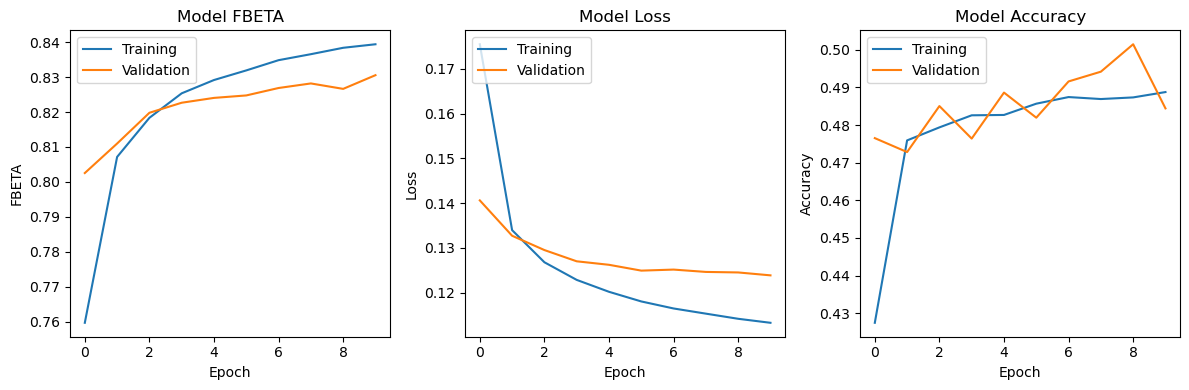

In [46]:
# Plot the training and validation accuracy and loss curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(historyMOB2.history['fbeta'])
plt.plot(historyMOB2.history['val_fbeta'])
plt.title('Model FBETA')
plt.ylabel('FBETA')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

plt.subplot(1, 3, 2)
plt.plot(historyMOB2.history['loss'])
plt.plot(historyMOB2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

plt.subplot(1, 3, 3)
plt.plot(historyMOB2.history['accuracy'])
plt.plot(historyMOB2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [56]:
# Loading the test images
samplesub = pd.read_csv(r"C:\Users\clemi\Downloads\Sidia\sample_submission_v2.csv")
#Because we are working with little memory, we will decrease the samples in the test dataset.
test = samplesub[0 : 15000]

In [57]:
# Initialize an empty list to store the images
x_test = []
y_test = []
# Loop through the test DataFrame

for image_name, tags in tqdm(test.values, miniters=1000):
    # Read the image file
    arr = cv2.imread(r'C:\Users\clemi\Downloads\Sidia\test-jpg\test-jpg\test-jpg/{}.jpg'.format(image_name))
    # Resize the image to (64, 64)
    x_test.append(cv2.resize(arr, (128, 128)))
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    y_test.append(targets)
x_test = np.array(x_test, np.float16)/255.0
y_test = np.array(y_test, np.uint8)

100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [00:16<00:00, 889.83it/s]


In [58]:
#Test Dataset
_, x_test, _, y_test = train_test_split(x_test, y_test, test_size = 0.9, shuffle = True, random_state = 1)

print("test data shape:",x_test.shape)
print("test label shape:",y_test.shape)

test data shape: (13500, 128, 128, 3)
test label shape: (13500, 17)


In [59]:
 # Evaluate the model on the test set
test_loss,test_fbeta,test_accuracy = model_MobNet2.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test F-beta:", test_fbeta)

422/422 [==============================] - 53s 125ms/step - loss: 0.9422 - fbeta: 0.3971 - accuracy: 0.0093
Test Loss: 0.9421972632408142
Test Accuracy: 0.009259259328246117
Test F-beta: 0.39706653356552124


In [48]:
#  Evaluate the model on the val set
test_loss,test_fbeta,test_accuracy = model_MobNet2.evaluate(x_val, y_val)
print("val Loss:", test_loss)
print("val Accuracy:", test_accuracy)
print("val F-beta:", test_fbeta)

253/253 [==============================] - 33s 132ms/step - loss: 0.1239 - fbeta: 0.8304 - accuracy: 0.4844
Test Loss: 0.12387751042842865
Test Accuracy: 0.4844367504119873
Test F-beta: 0.8304212093353271


# MobNet + 2D2PCA

In [14]:
#Place the train.csv file
path = pd.read_csv(r"C:\Users\clemi\Downloads\planet-understanding-the-amazon-from-space\train_v2.csv\train_v2.csv")

#Two lists to store images and labels
x_train = []
y_train = []

# Flatten the list of tags
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in path['tags'].values])))

# Create a label map for the unique tags in the dataset
label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

# Loop through the training DataFrame
for f, tags in tqdm(path.values, miniters=1000):
    # Read the image file
    img = cv2.imread(r'C:\Users\clemi\Downloads\Sidia\train-jpg\train-jpg/{}.jpg'.format(f))
    # Resize the image to (64, 64)
    targets = np.zeros(17)
    # Loop through the additional test files DataFrame
    for t in tags.split(' '):
        # Set the corresponding target value to 1
        targets[label_map[t]] = 1 
    # Resize the image to (64, 64)
    x_train.append(cv2.resize(img, (64,64)))  
    y_train.append(targets)

# Normalization
x_train = np.array(x_train, np.float16) / 255.
y_train = np.array(y_train, np.uint8)

100%|███████████████████████████████████████████████████████████████████████████| 40479/40479 [01:16<00:00, 526.68it/s]


In [15]:
# Loading the test images
samplesub = pd.read_csv(r"C:\Users\clemi\Downloads\Sidia\sample_submission_v2.csv")

test = samplesub[0 : 40669]
files = samplesub[40669 : ]

# Initialize an empty list to store the images
x_test = []
y_test = []
# Loop through the test DataFrame

for image_name, tags in tqdm(test.values, miniters=1000):
    # Read the image file
    arr = cv2.imread(r'C:\Users\clemi\Downloads\Sidia\test-jpg\test-jpg\test-jpg/{}.jpg'.format(image_name))
    # Resize the image to (64, 64)
    x_test.append(cv2.resize(arr, (64, 64)))
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    y_test.append(targets)
    
for image_name, tags in tqdm(files.values, miniters=1000):
    # Read the image file
    arr = cv2.imread(r'C:\Users\clemi\Downloads\Sidia\test-jpg-additional\test-jpg-additional/{}.jpg'.format(image_name))
    # Resize the image to (64, 64)
    x_test.append(cv2.resize(arr, (64, 64)))
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    y_test.append(targets)

# Convert the list of images to a numpy array and normalize the pixel values
x_test = np.array(x_test, np.float16)/255.0
y_test = np.array(y_test, np.uint8)

100%|███████████████████████████████████████████████████████████████████████████| 20522/20522 [00:34<00:00, 587.15it/s]


In [19]:
import tensorflow as tf
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNet

# Split the dataset into training, validation and testing
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
_, x_test, _, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

# Resize the images to the size required by the pre-trained model
input_shape = (64, 64, 3)
x_train_resized = np.array([tf.image.resize(image, input_shape[:2]) for image in x_train])
x_val_resized = np.array([tf.image.resize(image, input_shape[:2]) for image in x_val])
x_test_resized = np.array([tf.image.resize(image, input_shape[:2]) for image in x_test])

# Load the pre-trained model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

# Extract features from images using pre-trained model
train_features = base_model.predict(x_train_resized)
val_features = base_model.predict(x_val_resized)
test_features = base_model.predict(x_test_resized)

# Dimensionality reduction using PCA
n_components = 128
pca = PCA(n_components=n_components)
train_features_pca = pca.fit_transform(train_features.reshape(train_features.shape[0], -1))
val_features_pca = pca.transform(val_features.reshape(val_features.shape[0], -1))
test_features_pca = pca.transform(test_features.reshape(test_features.shape[0], -1))

# Create the classification model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(n_components,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(34, activation='relu'),
    tf.keras.layers.Dense(17, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# Train the model
h = model.fit(train_features_pca, y_train, validation_data=(val_features_pca, y_val), epochs=100, batch_size=128)



479/479 [==============================] - 19s 39ms/step
Epoch 1/100
162/162 [==============================] - 1s 2ms/step - loss: 0.2959 - fbeta: 0.6326 - val_loss: 0.1912 - val_fbeta: 0.7192
Epoch 2/100
162/162 [==============================] - 0s 2ms/step - loss: 0.1893 - fbeta: 0.7147 - val_loss: 0.1747 - val_fbeta: 0.7406
Epoch 3/100
162/162 [==============================] - 0s 2ms/step - loss: 0.1782 - fbeta: 0.7308 - val_loss: 0.1685 - val_fbeta: 0.7442
Epoch 4/100
162/162 [==============================] - 0s 2ms/step - loss: 0.1720 - fbeta: 0.7407 - val_loss: 0.1654 - val_fbeta: 0.7492
Epoch 5/100
162/162 [==============================] - 0s 2ms/step - loss: 0.1681 - fbeta: 0.7464 - val_loss: 0.1625 - val_fbeta: 0.7527
Epoch 6/100
162/162 [==============================] - 0s 2ms/step - loss: 0.1650 - fbeta: 0.7507 - val_loss: 0.1616 - val_fbeta: 0.7662
Epoch 7/100
162/162 [==============================] - 0s 2ms/step - loss: 0.1634 - fbeta: 0.7559 - val_loss: 0.1606 - va

Epoch 58/100
162/162 [==============================] - 0s 2ms/step - loss: 0.1384 - fbeta: 0.7946 - val_loss: 0.1578 - val_fbeta: 0.7707
Epoch 59/100
162/162 [==============================] - 0s 2ms/step - loss: 0.1376 - fbeta: 0.7953 - val_loss: 0.1571 - val_fbeta: 0.7718
Epoch 60/100
162/162 [==============================] - 0s 2ms/step - loss: 0.1379 - fbeta: 0.7953 - val_loss: 0.1586 - val_fbeta: 0.7696
Epoch 61/100
162/162 [==============================] - 0s 2ms/step - loss: 0.1387 - fbeta: 0.7936 - val_loss: 0.1578 - val_fbeta: 0.7720
Epoch 62/100
162/162 [==============================] - 0s 2ms/step - loss: 0.1372 - fbeta: 0.7959 - val_loss: 0.1585 - val_fbeta: 0.7693
Epoch 63/100
162/162 [==============================] - 0s 2ms/step - loss: 0.1375 - fbeta: 0.7958 - val_loss: 0.1585 - val_fbeta: 0.7739
Epoch 64/100
162/162 [==============================] - 0s 2ms/step - loss: 0.1373 - fbeta: 0.7962 - val_loss: 0.1577 - val_fbeta: 0.7709
Epoch 65/100
162/162 [============

In [21]:
# Evaluate the model on the test set
score = model.evaluate(test_features_pca, y_test)

print("Loss:", score[0])
print("Fbeta Score:", score[1])


479/479 [==============================] - 0s 716us/step - loss: 1.0393 - fbeta: 0.4010
Loss: 1.0392926931381226
Fbeta Score: 0.40098801255226135


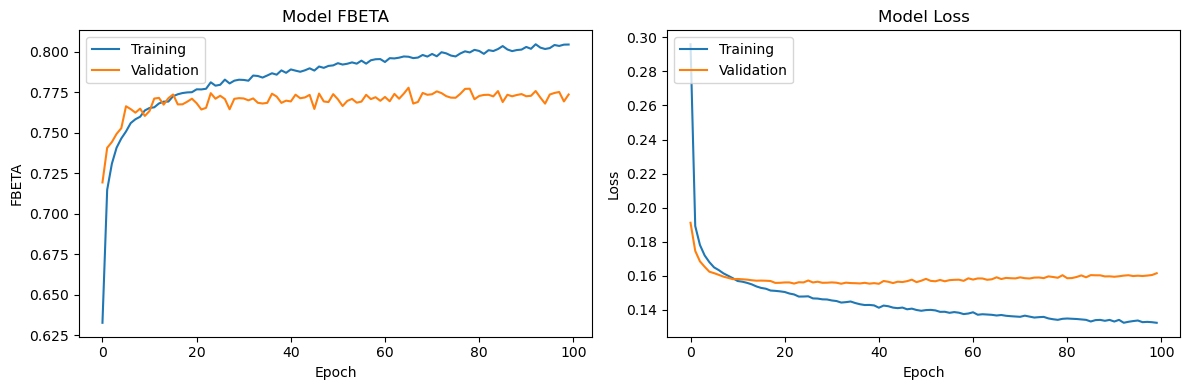

In [20]:
# Plot the training and validation accuracy and loss curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(h.history['fbeta'])
plt.plot(h.history['val_fbeta'])
plt.title('Model FBETA')
plt.ylabel('FBETA')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')


plt.tight_layout()
plt.show()